In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set the value of treatment effect

In [2]:
BETA = 8

## Generate synthetic data

In [11]:
data = dowhy.datasets.linear_dataset(BETA,
                                    num_common_causes=2, # confounders
                                    num_samples=5000,
                                    num_instruments=2, # instrument variables
                                    num_effect_modifiers=1, # features
                                    treatment_is_binary=True,
                                    stddev_treatment_noise=5,
                                    num_treatments=1)

df = data['df']

df.head()

,X0,Z0,Z1,W0,W1,v0,y
0,-0.918315,0.0,0.102747,0.259252,1.139336,True,5.644823
1,-0.662431,1.0,0.218614,-0.596461,0.807450,True,5.005966
2,0.414302,1.0,0.635194,-0.389247,-0.570277,True,8.587625
3,-0.575869,0.0,0.491916,1.119905,1.771579,True,8.450914
4,0.386357,1.0,0.143346,0.195709,-0.034058,True,9.623193


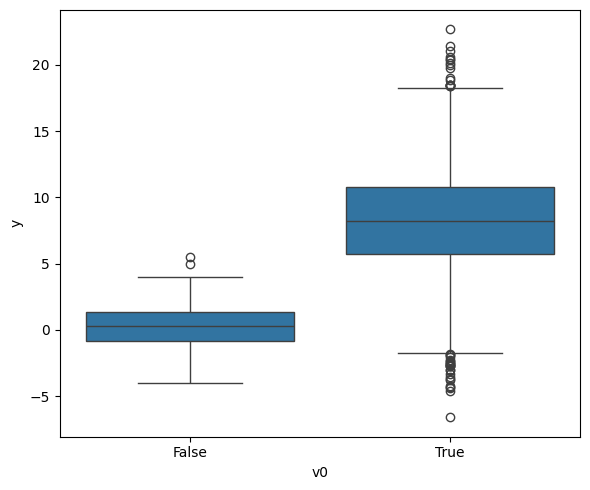

In [12]:
plt.figure(figsize=(6,5))

sns.boxplot(y='y', x='v0', data=df)

plt.tight_layout()

## Visualize causal pathway

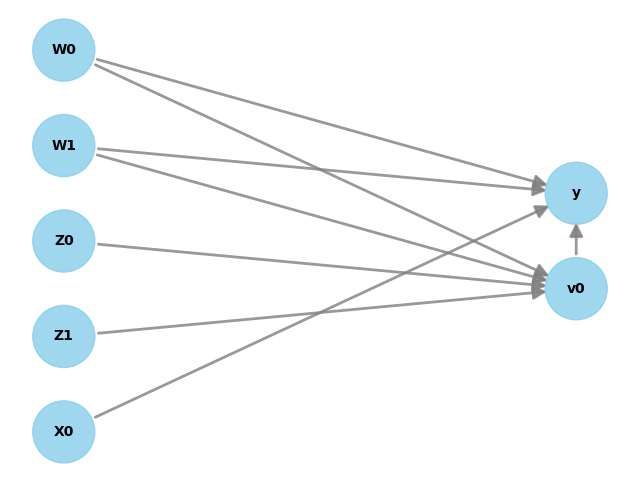

In [13]:
model = CausalModel(data=data['df'],
                   treatment=data['treatment_name'],
                   outcome=data['outcome_name'],
                   graph=data['gml_graph'])

model.view_model()

In [14]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)

print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W0,W1])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,U) = P(y|v0,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [15]:
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable")

print(causal_estimate.value)

8.218755524405902


In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(
    identified_estimand, 
    method_name="iv.econml.dml.DML",
    control_value = 0,
    treatment_value = 1,
    confidence_intervals=False,
    method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                  'model_t': GradientBoostingRegressor(),
                                  "model_final":LassoCV(fit_intercept=False),
                                  'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                   "fit_params":{}})
print(dml_estimate.value)

7.4114527282113825


## Refute estimate

In [17]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")

print(res_random)

Refute: Add a random common cause
Estimated effect:8.218755524405902
New effect:8.218755524405902
p value:1.0

